In [3]:
import keras as k
import scipy

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import Dense, Activation
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
home = '/home/nandhini/aozel/periodicBox/alpp0.1/CFD/0.6/'
fsize = 5

In [ ]:
alpp_file = 'barAlpp' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
alpp = pd.read_csv(home+alpp_file,skiprows=21,skipfooter=33)
numpy_alpp = alpp.values

Us_file = 'tildeUs' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
Us = pd.read_csv(home+Us_file,skiprows=21,skipfooter=33)
Us = Us.values
numpy_Us = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Us])

Uf_file = 'tildeUf' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
Uf = pd.read_csv(home+Uf_file,skiprows=21,skipfooter=33)
Uf = Uf.values
numpy_Uf = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Uf])

In [ ]:
numpy_alpp.shape, numpy_Us.shape, numpy_Uf.shape

In [ ]:
betaNum_file = 'normalizedEulerianDragCoeffNum' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
betaNum = pd.read_csv(home+betaNum_file,skiprows=19,skipfooter=4)
betaNum = betaNum.values
numpy_betaNum = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in betaNum])

In [ ]:
betaDom_file = 'normalizedEulerianDragCoeffDom' + str(fsize) + 'X' + str(fsize) + 'X' + str(fsize)
betaDom = pd.read_csv(home+betaDom_file,skiprows=19,skipfooter=4)
betaDom = betaDom.values
numpy_betaDom = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in betaDom])

In [ ]:
numpy_betaNum.shape, numpy_betaDom.shape

In [ ]:
numpy_ratio = numpy_betaNum / numpy_betaDom
numpy_ratio.shape

In [ ]:
original_table = np.concatenate((numpy_alpp,numpy_Us, numpy_Uf ),axis=1)

In [ ]:
original_table.shape

In [ ]:
nx = 80
ny = 80
nz = 320
dx = 1

In [ ]:
index1=0
npData=7

myData = np.zeros( ((nx-2)*(ny-2)*(nz-2), npData * (2*dx +1)**3) );
target = np.zeros((nx-2)*(ny-2)*(nz-2))
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            
            
            index2 = 0;
            for ii in range(-dx,dx+1):
                for jj in range(-dx,dx+1):
                    for kk in range(-dx,dx+1):
                        stencil= i+ii + (j+jj)*nx + (k+kk)*nx*ny;
                        target[index1] = numpy_ratio[stencil,-1]
                        temp = original_table[stencil][:]
                        for ind in range(npData):
                            myData[index1,index2] = temp[ind];
                            index2 = index2 + 1
            index1 = index1 +1                   
    print(i)

In [ ]:
myData.shape, target.shape

In [ ]:
pickle.dump( myData, open( "myData.pickle", "wb" ) )
pickle.dump( target, open( "target.pickle", "wb" ) )

In [5]:
myData = pickle.load( open( "myData.pickle", "rb" ) )
target = pickle.load( open( "target.pickle", "rb" ) )

In [6]:
X_train, X_test, y_train, y_test = train_test_split(myData, target, test_size=0.33, random_state=42)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_realCV_norm = X_test_norm[10000:][:]
X_realTT_norm = X_test_norm[:10000][:]
y_realCV = y_test[10000:][:]
y_realTT = y_test[:10000][:]

In [18]:
X_train_norm.shape, X_realCV_norm.shape, X_realTT_norm.shape

((1296257, 189), (628455, 189), (10000, 189))

In [ ]:
#nn = MLPRegressor(hidden_layer_sizes=(100,))

In [76]:
model = Sequential()

model.add(Dense(160, activation='relu', kernel_initializer='normal',input_dim=X_train_norm.shape[-1]))
model.add(Dense(160, activation='relu', kernel_initializer='normal'))
model.add(Dense(80, activation='relu', kernel_initializer='normal'))
model.add(Dense(64,kernel_initializer='normal', activation='relu'))
model.add(Dense(64,kernel_initializer='normal', activation='relu'))
model.add(Dense(32,kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal',activation='relu'))
model.add(Dense(8,kernel_initializer='normal', activation='relu'))
model.add(Dense(4,kernel_initializer='normal', activation='relu'))
model.add(Dense(1,kernel_initializer='normal', activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.load_weights('weights.hdf5')
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
model.fit(X_train_norm, y_train, batch_size=128, epochs=20, verbose=0, validation_data=(X_realCV_norm, y_realCV), callbacks=[checkpointer])

Epoch 00000: val_loss improved from inf to 0.36593, saving model to weights.hdf5
Epoch 00001: val_loss improved from 0.36593 to 0.36062, saving model to weights.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve


KeyboardInterrupt: 

In [ ]:
#nn = MLPRegressor(hidden_layer_sizes=(100,),max_iter=2)
#nn.fit(X_train_norm, y_train)

In [77]:
y_predict = model.predict(X_realTT_norm)

(array([   1.,    0.,    0.,    0.,    1.,    0.,    1.,    0.,    9.,  988.]),
 array([-60.41237113, -53.71116901, -47.00996689, -40.30876476,
        -33.60756264, -26.90636051, -20.20515839, -13.50395626,
         -6.80275414,  -0.10155202,   6.59965011]),
 <a list of 10 Patch objects>)

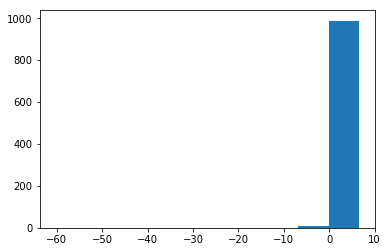

In [78]:
plt.hist(y_realTT[:1000])

In [79]:
y_realTT

array([ 0.29949287,  0.27085262,  1.0006401 , ...,  0.89131239,
        0.86103012,  0.65717939])

(0, 2)

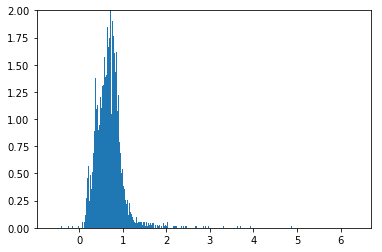

In [80]:
plt.hist(y_predict,1000,normed=True);
plt.ylim([0,2])

In [81]:
scipy.stats.pearsonr(y_realTT.reshape(-1), y_predict.reshape(-1))

(-0.020317290948872323, 0.04218557495441852)

(-1, 1)

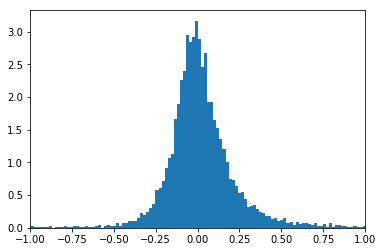

In [100]:
error_percent = (y_predict.reshape(-1) - y_realTT.reshape(-1))/y_realTT.reshape(-1)
ah = plt.hist(error_percent,5000,normed=True)
plt.xlim([-1, 1])

In [95]:
ah[0].shape

(1000,)

ValueError: x and y must be the same size

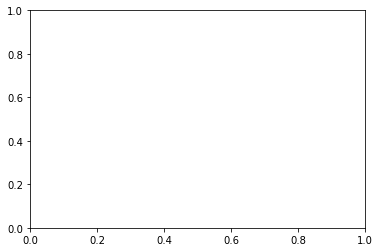

In [92]:
plt.scatter(ah[1],ah[0])

(-1, 1)

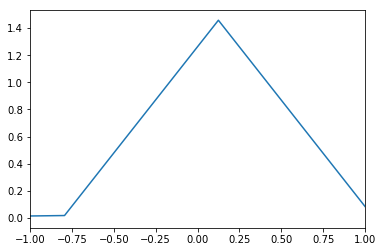

In [88]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( error_percent )
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(error_percent), max(error_percent), 100 )
# plot the results
plt.plot( dist_space, kde(dist_space) )
plt.xlim([-1,1])

In [ ]:
#Us_2 = np.array([[float(x[0].split()[0][1:]), float(x[0].split()[1]), float(x[0].split()[2][:-1])] for x in Us])

In [ ]:
#Us[-1]

In [ ]:
#Us_2[-1]